# Predecessor follower model predictive control study

In [1]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import time
from tqdm.notebook import tqdm

In [2]:
from utils.step_reference import gen_step_ref
from dyn.linear_long import LinearLong
from alg.sparse_quad_pfmpc import SparseQuadPFMPC

### Platoon parameters

In [3]:
H = 100   # planning horizon
N = 10    # number of vehicles in platoon, including leader
dt = 0.1  # timestep
total_time = 10.0  # seconds
total_time += dt * H
d_des = 5   # desired spacing

# dynamics stuff
x_min = np.array([-np.inf, -np.inf, -np.inf])
x_max = np.array([np.inf, np.inf, np.inf])
u_min = np.array([-6.0])
u_max = np.array([6.0])
taus = [None] + [dt + (1 - dt) * (n-1) / N for n in range(1, N+1)]
# taus = [None] + [0.3 for _ in range(N)]
print(taus)
dyns = [None] + [LinearLong(dt, x_min, x_max, u_min, u_max, tau) for tau in taus[1:]]
n, m, p = dyns[1].n, dyns[1].m, dyns[1].p

# algorithm
q_vals = [None] + [1 for _ in range(N)]
q_p_vals = [None, 1] + [1 for _ in range(1, N)]
r_vals = [None] + [.1 for _ in range(N)]
Q = [None] + [q * np.eye(p) for q in q_vals[1:]]
Q_p = [None] + [q_p * np.eye(p) for q_p in q_p_vals[1:]]
R = [None] + [r * np.eye(m) for r in r_vals[1:]]
pfmpc = [None] + [SparseQuadPFMPC(Q[i], Q_p[i], R[i], dyns[i], u_min, u_max, H)
                  for i in range(1, N+1)]

[None, 0.1, 0.19, 0.28, 0.37, 0.45999999999999996, 0.55, 0.64, 0.73, 0.82, 0.9099999999999999]


### Reference trajectory - Acceleration

In [4]:
dist_start = 1.0
dist_end = 6.0
v_start = 20.
v_end = 25.

x_ref, t_range = gen_step_ref(total_time, dt, dist_start, dist_end, 
                              v_start, v_end)
y_ref = x_ref[:2, :]
T = len(t_range)
t_range_mpc = t_range[:T-H]

### Randomized initial conditions

In [5]:
n_trials = 100  # number of trials
tol = .1
fail_init_conditions = []
n_fail = 0

for j in tqdm(range(n_trials), desc=" trial", position=0, leave=False):
    x_pfmpc = [np.zeros((n, T-H)) for _ in range(N + 1)]
    u_pfmpc = [np.zeros((m, T-H-1)) for _ in range(N + 1)]

    # zeroth vehicle is virtual leader
    x_pfmpc[0] = x_ref[:, :T-H]
    u_pfmpc[0][:, :T-H-1] = x_ref[2, :T-H-1]

    init_spacing_noise = 3
    init_vel_noise = 5
    init_accel_noise = 2
    noise_cov = np.diag(np.array([init_spacing_noise, init_vel_noise, 
                                init_accel_noise]))
    noise = np.random.multivariate_normal(np.zeros(n), noise_cov, N)
    init_conditions = []

    # initial conditions: start in correct place with desired spacing, velocity, 
    # and acceleration plus some noise
    for i in range(1, N + 1):
        d = 0 if i == 1 else d_des
        x_pfmpc[i][:, 0] = np.array([-(i-1)*d, x_pfmpc[0][1, 0], x_pfmpc[0][2, 0]])
        x_pfmpc[i][:, 0] += noise[i-1, :]
        init_conditions.append(x_pfmpc[i][:, 0])

    # initialize assumed states, controls, and output for first timestep
    x_a_pfmpc = [np.zeros((n, H + 1)) for _ in range(N + 1)]
    x_a_pfmpc[0] = x_pfmpc[0][:, :H+1]
    for i in range(1, N + 1):
        x_a_pfmpc[i][:, 0] = x_pfmpc[i][:, 0]

    y_a_pfmpc = [np.zeros((p, H + 1)) for _ in range(N + 1)]
    y_a_pfmpc[0] = x_pfmpc[0][:2, :H+1]
    for i in range(1, N + 1):
        y_a_pfmpc[i][:, 0] = dyns[i].sense(x_a_pfmpc[i][:, 0])

    u_a_pfmpc = [np.zeros((m, H)) for _ in range(N + 1)]
    u_a_pfmpc[0] = u_pfmpc[0][:H]

    for i in range(1, N+1):
        for k in range(H):
            x_a_pfmpc[i][:, k+1] = dyns[i].forward(x_a_pfmpc[i][:, k], 
                                                   u_a_pfmpc[i][:, k])
            y_a_pfmpc[i][:, k+1] = dyns[i].sense(x_a_pfmpc[i][:, k+1])

    x_a_pfmpc_prev = copy.deepcopy(x_a_pfmpc)
    y_a_pfmpc_prev = copy.deepcopy(y_a_pfmpc)
    u_a_pfmpc_prev = copy.deepcopy(u_a_pfmpc)

    no_soln = False
    for k in range(T - H - 1):
        for i in range(1, N + 1):
            x_0 = x_pfmpc[i][:, k]
            y_a = y_a_pfmpc_prev[i]
            y_pred_a = y_a_pfmpc_prev[i-1]
            d = 0 if i == 1 else d_des

            z_opt, prob = pfmpc[i].control(x_0, y_a, y_pred_a, d)
            if 'optimal' not in prob.status:
                # print(f"timestep {k}, vehicle {i}, problem returned: {prob.status}")
                # print("initial conditions:")
                # for i in range(N):
                    # print(f"vehicle {i}: {init_conditions[i]}")
                no_soln = True
                n_fail += 1
                fail_init_conditions.append(init_conditions)
                break

            x_opt = np.zeros((n, H+1))
            u_opt = np.zeros((m, H))
            y_opt = np.zeros((p, H+1))

            x_opt[:, 0] = x_0
            u_opt[:, 0] = z_opt[:m]
            y_opt[:, 0] = z_opt[m:m+p]
            for t, j in enumerate(range(m+p, len(z_opt), n+m+3*p)):
                x_opt[:, t+1] = z_opt[j:j+n]
                u_opt[:, t+1] = z_opt[j+n:j+n+m]
                y_opt[:, t+1] = z_opt[j+n+m:j+n+m+p]
            x_opt[:, H] = dyns[i].forward(x_opt[:, H-1], u_opt[:, H-1])
            y_opt[:, H] = dyns[i].sense(x_opt[:, H])

            u_pfmpc[i][:, k] = u_opt[:, 0]
            x_pfmpc[i][:, k+1] = dyns[i].forward(x_0, u_opt[:, 0])

            # update assumed state, control, input
            u_a_pfmpc[i][:, :H-1] = u_opt[:, 1:H]
            u_a_pfmpc[i][:, H-1] = np.zeros((dyns[i].m))
            x_a_pfmpc[i][:, 0] = x_opt[:, 1]
            y_a_pfmpc[i][:, 0] = dyns[i].sense(x_a_pfmpc[i][:, 0])
            for t in range(H):
                x_a_pfmpc[i][:, t+1] = dyns[i].forward(x_a_pfmpc[i][:, t], 
                                                    u_a_pfmpc[i][:, t])
                y_a_pfmpc[i][:, t+1] = dyns[i].sense(x_a_pfmpc[i][:, t+1])
        
        if no_soln:
        #     fig, ax = plt.subplots(2, 1, figsize=(8, 4), sharex=True)
        #     fig.suptitle(f"timestep {k}, vehicle {i} failure", size=16)
        #     fig.subplots_adjust(top=0.9)
        #     for i in range(N+1):
        #         ax[0].plot(t_range[:H+1], y_a_pfmpc_prev[i][0, :], 
        #                 label=f"{i} assumed")
        #         ax[1].plot(t_range[:H+1], y_a_pfmpc_prev[i][1, :], 
        #                 label=f"{i} assumed")
        #     ax[0].set_ylabel("position [m]")
        #     ax[0].legend(bbox_to_anchor=(1.02, 0.5), loc='center left')
        #     ax[1].set_ylabel("velocity [m/s]")
        #     ax[1].set_xlabel("time [s]")
        #     ax[1].legend(bbox_to_anchor=(1.02, 0.5), loc='center left')
            break
        
        x_a_pfmpc[0] = x_ref[:, k+1:k+H+2]
        y_a_pfmpc[0] = x_ref[:2, k+1:k+H+2]
        u_a_pfmpc[0] = x_ref[2, k+1:k+H+1]

        x_a_pfmpc_prev = copy.deepcopy(x_a_pfmpc)
        y_a_pfmpc_prev = copy.deepcopy(y_a_pfmpc)
        u_a_pfmpc_prev = copy.deepcopy(u_a_pfmpc)
    
    for i in range(1, N):
        d = 0 if i == 1 else d_des * (i - 1)
        d_tilde = np.array([d, 0, 0])
        if not np.linalg.norm(x_pfmpc[i][:, -1] - x_pfmpc[0][:, -1] + d_tilde) < tol:
            # print(f"initial conditions:\n{init_conditions}")
            # print(f"vehicle {i}: {x_pfmpc[i][:, -1]}")
            # print(f"vehicle {i} des: {x_pfmpc[0][:, -1] - d_tilde}")
            fail_init_conditions.append(init_conditions)
            break

print(f"number of failure init conditions: {n_fail}")

 trial:   0%|          | 0/100 [00:00<?, ?it/s]

number of failure init conditions: 0


In [6]:
plot_inds = np.linspace(1, N, 10).round().astype(int)

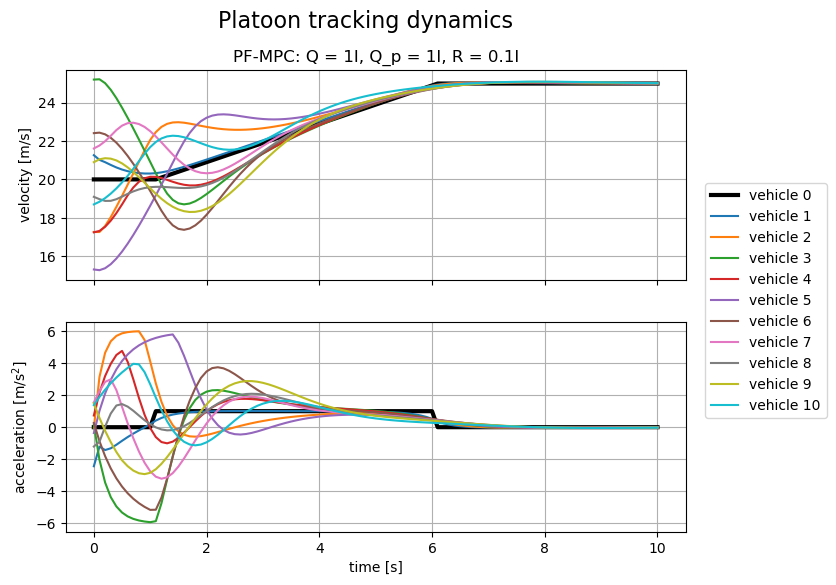

In [7]:
fig, ax = plt.subplots(2, 1, figsize=(8, 6), sharex=True)
fig.suptitle("Platoon tracking dynamics", size=16)
ax[0].set_title(f"PF-MPC: Q = {q_vals[2]}I, Q_p = {q_p_vals[2]}I, R = {r_vals[2]}I")
fig.subplots_adjust(top=0.88)

ax[0].plot(t_range_mpc, x_pfmpc[0][1, :], label=f"vehicle 0", 
           color='k', linewidth=3.0)
ax[1].plot(t_range_mpc, x_pfmpc[0][2, :], label=f"vehicle 0",
           color='k', linewidth=3.0)
for i in plot_inds:
    ax[0].plot(t_range_mpc, x_pfmpc[i][1, :], label=f"vehicle {i}")
    ax[1].plot(t_range_mpc, x_pfmpc[i][2, :], label=f"vehicle {i}")

ax[0].set_ylabel("velocity [m/s]")
ax[1].set_ylabel(r"acceleration [m/s$^2$]")
ax[1].set_xlabel("time [s]")
ax[0].grid()
ax[1].grid()
ax[0].legend(bbox_to_anchor=(1.02, -0.1), loc="center left");

In [8]:
d_error_pfmpc = [np.zeros(T-H) for _ in range(N + 1)]
v_error_pfmpc = [np.zeros(T-H) for _ in range(N + 1)]
for i in range(1, N + 1):
    d = (i-1) * d_des
    d_error_pfmpc[i] = x_pfmpc[i][0, :] - x_pfmpc[0][0, :] + d
    v_error_pfmpc[i] = x_pfmpc[i][1, :] - x_pfmpc[0][1, :]

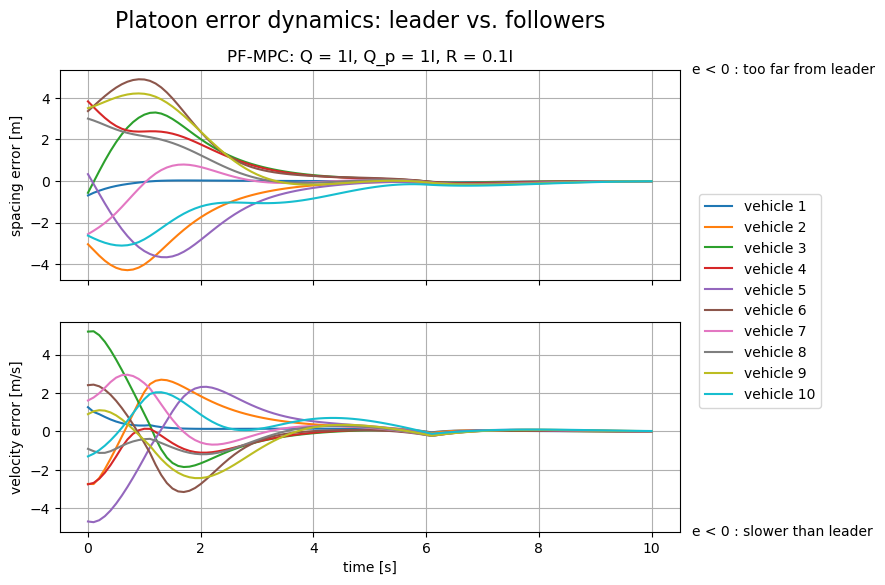

In [9]:
fig, ax = plt.subplots(2, 1, figsize=(8, 6), sharex=True)
fig.suptitle("Platoon error dynamics: leader vs. followers", size=16)
ax[0].set_title(f"PF-MPC: Q = {q_vals[2]}I, Q_p = {q_p_vals[2]}I, R = {r_vals[2]}I")
fig.subplots_adjust(top=0.88)

for i in plot_inds:
    ax[0].plot(t_range[:T-H], d_error_pfmpc[i], label=f"vehicle {i}")
    ax[1].plot(t_range[:T-H], v_error_pfmpc[i], label=f"vehicle {i}")

ax[0].text(1.02, 1.0, "e < 0 : too far from leader", va='center', 
           transform=ax[0].transAxes)
ax[1].text(1.02, 0.0, "e < 0 : slower than leader", va='center', 
           transform=ax[1].transAxes)

ax[0].set_ylabel("spacing error [m]")
ax[1].set_ylabel("velocity error [m/s]")
ax[1].set_xlabel("time [s]")
ax[0].grid()
ax[1].grid()
ax[1].legend(bbox_to_anchor=(1.02, 1.1), loc="center left");

In [10]:
d_error_pfmpc = [np.zeros(T-H) for _ in range(N + 1)]
v_error_pfmpc = [np.zeros(T-H) for _ in range(N + 1)]
for i in range(1, N + 1):
    d = 0 if i == 1 else d_des
    d_error_pfmpc[i] = x_pfmpc[i][0, :] - x_pfmpc[i-1][0, :] + d
    v_error_pfmpc[i] = x_pfmpc[i][1, :] - x_pfmpc[i-1][1, :]

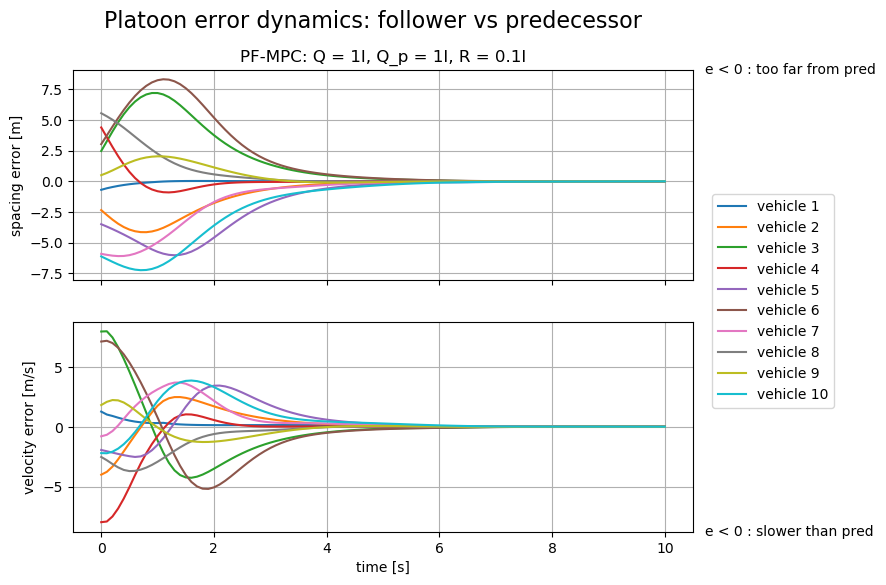

In [11]:
fig, ax = plt.subplots(2, 1, figsize=(8, 6), sharex=True)
fig.suptitle("Platoon error dynamics: follower vs predecessor", size=16)
ax[0].set_title(f"PF-MPC: Q = {q_vals[2]}I, Q_p = {q_p_vals[2]}I, R = {r_vals[2]}I")
fig.subplots_adjust(top=0.88)

for i in plot_inds:
    ax[0].plot(t_range[:T-H], d_error_pfmpc[i], label=f"vehicle {i}")
    ax[1].plot(t_range[:T-H], v_error_pfmpc[i], label=f"vehicle {i}")

ax[0].text(1.02, 1.0, "e < 0 : too far from pred", va='center', 
           transform=ax[0].transAxes)
ax[1].text(1.02, 0.0, "e < 0 : slower than pred", va='center', 
           transform=ax[1].transAxes)

ax[0].set_ylabel("spacing error [m]")
ax[1].set_ylabel("velocity error [m/s]")
ax[1].set_xlabel("time [s]")
ax[0].grid()
ax[1].grid()
ax[1].legend(bbox_to_anchor=(1.02, 1.1), loc="center left");

In [12]:
print(len(fail_init_conditions))

0


In [13]:
for i in range(len(fail_init_conditions)):
    print(fail_init_conditions[i].shape)
fail_init_conditions = np.array(fail_init_conditions)
print(fail_init_conditions.shape)
for i in range(fail_init_conditions.shape[0]):
    np.savetxt(f"fail_init_conditions_{i}.csv", fail_init_conditions[i, :, :])

(0,)
